# Virtual Adversarial Training 

# A Regularization Method for Supervised and Semi-Supervised Learning

------------------------------------
#### Authors :
- Penda TOURE
- Fernanda TCHOUACHEU
- Mohamed NIANG
-----------------------------------

#  Table of Contents

I. Introduction

II. Importing packages 

III. Load data and preprocessing

IV. VAT for semi-supervised learning on MNIST dataset

V. Training Semi-supervised with VATModel 

VI. Training fully supervised without VATModel

# I. Introduction 

<p style='text-align: justify;'>
In this project, we are faced with a semi-supervised learning problem with MNIST data. The goal here is to make a prediction on MNIST data using only 100 labels.
To do so, we use a regularization method based on the virtual loss of opponents: a new measure of the local uniformity of the conditional distribution of the input label. The virtual adversarial loss is defined as the robustness of the conditional distribution of the label around each input data point with respect to local perturbations. In contrast to contradictory training, this method defines the contradictory orientation without label information and is therefore applicable to semi-supervised learning.
</p>

In [1]:
### Ignore warning
import warnings
warnings.filterwarnings("ignore")

# II. Importing packages 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from functools import reduce
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.generic_utils import to_list
from keras.engine.training import Model
from keras.layers import Input
import keras.backend as K

Using TensorFlow backend.


# III. Load data and preprocessing

In [2]:
n_classes = 10
batch_size = 128
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28

np.random.seed(1337)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'Train samples')
print(X_test.shape[0], 'Test samples')

X_train shape: (60000, 28, 28, 1)
60000 Train samples
10000 Test samples


# IV. VAT for semi-supervised learning on MNIST dataset

In [ ]:
class VATModel(Model):
    def __init__(self, model, input_shape=(28, 28, 1), xi=1e-3, eps=1.0, ip=1):  
        vat_inputs = [Input(shape=input_shape) for i in model.inputs]  
        vat_outputs = model(vat_inputs)
        super(VATModel, self).__init__(inputs=vat_inputs,
                                       outputs=vat_outputs)
        self._vat_loss = None
        self.setup_vat_loss(eps=eps, xi=xi, ip=ip)

    def setup_vat_loss(self, eps, xi, ip):
        self._vat_loss = self.vat_loss(eps, xi, ip)
        self.add_loss(self._vat_loss)
        return self

    def vat_loss(self, eps, xi, ip):
        normal_outputs = [K.stop_gradient(x) for x in to_list(self.outputs)]
        d_list = [K.random_normal(K.shape(x)) for x in self.inputs]

        for _ in range(ip):
            new_inputs = [x + self.normalize_vector(d)*xi
                          for (x, d) in zip(self.inputs, d_list)]
            new_outputs = to_list(self.call(new_inputs))
            klds = [K.sum(self.kld(normal, new))
                    for normal, new in zip(normal_outputs, new_outputs)]
            kld = reduce(lambda t, x: t+x, klds, 0)
            d_list = [K.stop_gradient(d) for d in K.gradients(kld, d_list)]

        new_inputs = [x + self.normalize_vector(d) * eps
                      for (x, d) in zip(self.inputs, d_list)]
        y_perturbations = to_list(self.call(new_inputs))
        klds = [K.mean(self.kld(normal, new))
                for normal, new in zip(normal_outputs, y_perturbations)]
        kld = reduce(lambda t, x: t + x, klds, 0)
        return kld

    @staticmethod
    def normalize_vector(x):
        z = K.sum(K.batch_flatten(K.square(x)), axis=1)
        while K.ndim(z) < K.ndim(x):
            z = K.expand_dims(z, axis=-1)
        return x / (K.sqrt(z) + K.epsilon())

    @staticmethod
    def kld(p, q):
        v = p * (K.log(p + K.epsilon()) - K.log(q + K.epsilon()))
        return K.sum(K.batch_flatten(v), axis=1, keepdims=True)


class SemiSupervisedVATModel(Model):
    def __init__(self, model, input_shape=(28, 28, 1), xi=1e-3, eps=1.0, ip=1):
        supervised_model = model
        unsupervised_model = VATModel(model, input_shape=input_shape,
                                      xi=xi, eps=eps, ip=ip)
        all_inputs = supervised_model.inputs + unsupervised_model.inputs
        all_outputs = supervised_model.outputs + unsupervised_model.outputs
        super(SemiSupervisedVATModel, self).__init__(inputs=all_inputs,
                                                     outputs=all_outputs)

        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def compile(self, optimizer, loss, metrics=[]):
        self.supervised_model.compile(optimizer=optimizer,
                                      loss=loss,
                                      metrics=metrics)
        self.unsupervised_model.compile(optimizer=optimizer, loss=[None])

    @property
    def metrics_names(self):
        return ["sup_" + m for m in self.supervised_model.metrics_names] + \
               ["unsup_" + m for m in self.unsupervised_model.metrics_names]

    def fit(self, x=None, y=None, batch_size=32, epochs=1):
        # One item for supervised, one for unsupervised
        assert len(x) == len(y) == 2
        n_sup = x[0].shape[0]
        n_unsup = x[1].shape[0]
        n = max([n_sup, n_unsup])
        for e in range(epochs):
            n_batches = n // batch_size
            loss_sup = np.array([0.] * len(self.supervised_model.metrics_names))
            loss_unsup = np.array([0.] * len(self.supervised_model.metrics_names))
            for b in range(n_batches):
                indices_sup = np.random.randint(low=0, high=n_sup,
                                                   size=batch_size)
                indices_unsup = np.random.randint(low=0, high=n_unsup,
                                                     size=batch_size)
                x_sup_batch = x[0][indices_sup]
                y_sup_batch = y[0][indices_sup]
                x_unsup_batch = x[1][indices_unsup]
                loss_sup += self.supervised_model.train_on_batch(x_sup_batch,
                                                                 y_sup_batch)
                loss_unsup += self.unsupervised_model.train_on_batch(x_unsup_batch,
                                                                     None)
            loss_sup /= n_batches
            loss_unsup /= n_batches
            loss = np.stack((loss_sup, loss_unsup)).reshape((-1, ))
            s = "epoch {}/{}: ".format(e + 1, epochs)
            for i, name in enumerate(self.metrics_names):
                s += "{}: {} ".format(name, loss[i])
            print(s)
        return [-1., -1.]  

    def predict(self, x,
                batch_size=None,
                verbose=0,
                steps=None):
        return self.supervised_model.predict(x=x, batch_size=batch_size,
                                             verbose=verbose, steps=steps)

    def evaluate(self, x=None, y=None,
                 batch_size=None,
                 verbose=1,
                 sample_weight=None,
                 steps=None):
        return self.supervised_model.evaluate(x=x, y=y,
                                              sample_weight=sample_weight,
                                              batch_size=batch_size,
                                              verbose=verbose, steps=steps)

# V. Training Semi-supervised with VATModel 

In [ ]:
indices_supervised = np.random.randint(low=0, high=X_train.shape[0],
                                          size=X_train.shape[0] // 600)
indices_unsupervised = np.isin(np.arange(X_train.shape[0]),
                                  indices_supervised,
                                  invert=True)
X_train_sup = X_train[indices_supervised]
y_train_sup = y_train[indices_supervised]
X_train_unsup = X_train[indices_unsupervised]

In [6]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(n_classes, activation='softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model2 = SemiSupervisedVATModel(model=model2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [9]:
histories2 = model2.fit([X_train_sup, X_train_unsup],
           [y_train_sup, None],
           batch_size=batch_size, epochs=100)

histories2









epoch 1/100: sup_loss: 0.20574596107037982 sup_acc: 0.9828359207708779 unsup_loss: 0.29834638934430907 
epoch 2/100: sup_loss: 0.044388600543332817 sup_acc: 1.0 unsup_loss: 0.19162017065529138 
epoch 3/100: sup_loss: 0.01605260800430651 sup_acc: 0.9999832708779444 unsup_loss: 0.143958437876732 
epoch 4/100: sup_loss: 0.007326560106731221 sup_acc: 0.9999832708779444 unsup_loss: 0.12593697703880213 
epoch 5/100: sup_loss: 0.0044793255531929066 sup_acc: 0.9999832708779444 unsup_loss: 0.11350998877521756 
epoch 6/100: sup_loss: 0.0038929482886061167 sup_acc: 0.999949812633833 unsup_loss: 0.11039196119924939 
epoch 7/100: sup_loss: 0.0031759491887933733 sup_acc: 0.9999665417558886 unsup_loss: 0.11140048921874045 
epoch 8/100: sup_loss: 0.0025355960862542557 sup_acc: 0.9999665417558886 unsup_loss: 0.10881293170967755 
epoch 9/100: sup_loss: 0.0024037070429536894 sup_acc: 1.0 unsup_loss: 0.10759921237124366 
epoch 10/100: sup_loss: 0.0024267106793551133 sup_acc: 0.9999665417558886 uns

[-1.0, -1.0]

In [10]:
score2 = model2.evaluate(X_test, y_test)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

10000/10000 [==============================] - 1s 69us/step
Test loss: 0.5893054841025295
Test accuracy: 0.9215


# VI. Training fully supervised without VATModel 

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(n_classes, activation='softmax'))

In [36]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [ ]:
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [38]:
histories1 = model1.fit(X_train_sup, y_train_sup,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_test, y_test))

histories1

Train on 100 samples, validate on 10000 samples
Epoch 1/12
100/100 [==============================] - 1s 9ms/step - loss: 2.2913 - acc: 0.1100 - val_loss: 2.2095 - val_acc: 0.3410
Epoch 2/12
100/100 [==============================] - 0s 3ms/step - loss: 2.1509 - acc: 0.3200 - val_loss: 2.0931 - val_acc: 0.3118
Epoch 3/12
100/100 [==============================] - 0s 3ms/step - loss: 1.9288 - acc: 0.4800 - val_loss: 1.8449 - val_acc: 0.4330
Epoch 4/12
100/100 [==============================] - 0s 3ms/step - loss: 1.6894 - acc: 0.5400 - val_loss: 1.6648 - val_acc: 0.4634
Epoch 5/12
100/100 [==============================] - 0s 3ms/step - loss: 1.4502 - acc: 0.5600 - val_loss: 1.9307 - val_acc: 0.3279
Epoch 6/12
100/100 [==============================] - 0s 3ms/step - loss: 1.7393 - acc: 0.4600 - val_loss: 1.7142 - val_acc: 0.5244
Epoch 7/12
100/100 [==============================] - 0s 3ms/step - loss: 1.5175 - acc: 0.5500 - val_loss: 1.3537 - val_acc: 0.6363
Epoch 8/12
100/100 [========

In [39]:
score1 = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.0817532661437987
Test accuracy: 0.6756


In [40]:
histories1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

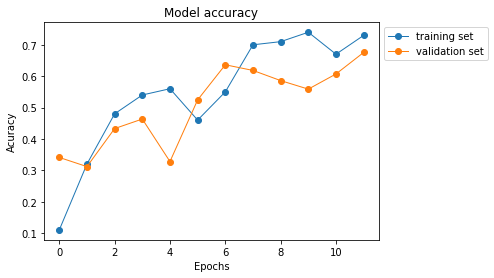

In [41]:
plt.plot(histories1.history['acc'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(histories1.history['val_acc'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("Model accuracy")
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

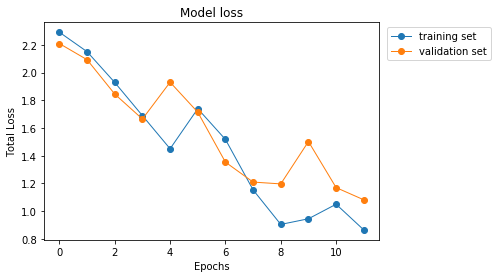

In [42]:
plt.plot(histories1.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(histories1.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("Model loss")
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))